In [0]:
from pyspark.sql.functions import col, when, to_timestamp, month
from pyspark.sql import functions as F
from pyspark.sql.types import NumericType
from pyspark.ml.linalg import VectorUDT

from pyspark.ml import Pipeline
from pyspark.ml.pipeline import PipelineModel
from pyspark.ml.feature import (
    StringIndexer, 
    VectorAssembler, 
    StandardScaler,
    PCA
)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from xgboost.spark import SparkXGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

In [0]:
display(
    dbutils.fs.ls("dbfs:/student-groups/Group_4_1/")
)

path,name,size,modificationTime
dbfs:/student-groups/Group_4_1/08f51b3e-da58-4e4d-9da0-e331eeb9b245/,08f51b3e-da58-4e4d-9da0-e331eeb9b245/,0,1763577618600
dbfs:/student-groups/Group_4_1/3f887a59-7aaf-44bd-ad75-d9ab2e382e22/,3f887a59-7aaf-44bd-ad75-d9ab2e382e22/,0,1763577618600
dbfs:/student-groups/Group_4_1/5Y/,5Y/,0,1763577618601
dbfs:/student-groups/Group_4_1/86b0469f-b9c6-4218-8869-aaeb39753cac/,86b0469f-b9c6-4218-8869-aaeb39753cac/,0,1763577618601
dbfs:/student-groups/Group_4_1/airport_codes.parquet/,airport_codes.parquet/,0,1763577618601
dbfs:/student-groups/Group_4_1/best_preds_final_test_5Y.parquet/,best_preds_final_test_5Y.parquet/,0,1763577618601
dbfs:/student-groups/Group_4_1/c505789c-684a-47b9-84e1-24d52ec7cb99/,c505789c-684a-47b9-84e1-24d52ec7cb99/,0,1763577618601
dbfs:/student-groups/Group_4_1/cv_model/,cv_model/,0,1763577618601
dbfs:/student-groups/Group_4_1/df_test_scaled.parquet/,df_test_scaled.parquet/,0,1763577618601
dbfs:/student-groups/Group_4_1/df_test_scaled_checkpoint.parquet/,df_test_scaled_checkpoint.parquet/,0,1763577618601


In [0]:
# 1 Removing duplicates, cancellation flights and column with null values > 12%
ch1 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_1/"
# 2 Remove data leakage columns and other columns after review
ch2 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_2/"
# 3 After imputing all the missing columns - new columns included in this step - HourlyPrecipitation_was_missing,wind_deg_imputed, wind_dir_sin,wind_dir_cos
ch3 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_3/"
# 4 Adding external holiday data
ch4 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_4/"
# Adding external holiday data, is_weekend, sky_conditions transformed
# one hot encoding of categorical variable
# converted string  to numeric
ch5 = "dbfs:/student-groups/Group_4_1/otpw_3M_checkpoint_5"

In [0]:
# Removing duplicates, cancellation flights, column with null values > 12%  and Data leakage column
yd1 = "dbfs:/student-groups/Group_4_1/otpw_clean_1Y_checkpoint_1/"
# Remove other columns after review
yd2 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_2/"
# 3 After imputing all the missing columns - new columns included in this step - HourlyPrecipitation_was_missing,wind_deg_imputed, wind_dir_sin,wind_dir_cos
yd3 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_3/"
# Adding external holiday data   new columns included in this step  - HourlyPrecipitation_was_missing,wind_deg_imputed, wind_dir_sin,wind_dir_cos
yd4 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_4/"
# Adding external holiday data, is_weekend, sky_conditions transformed
# one hot encoding of categorical variable
# converted string  to numeric
yd5 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_5/"

# removed the holiday columns in the process. I’ve added them back now, and all the categorical variables are one-hot encoded with the ohe prefix.
yd7 = "dbfs:/student-groups/Group_4_1/otpw_1Y_checkpoint_7/"

In [0]:
def show_schema_and_sample(path, n=10):
    df = spark.read.parquet(path)
    df.printSchema()
    display(df.limit(n))

show_schema_and_sample(yd7)

root
 |-- HourlyPrecipitation: double (nullable = true)
 |-- HourlySeaLevelPressure: double (nullable = true)
 |-- HourlyAltimeterSetting: double (nullable = true)
 |-- DEP_TIME: integer (nullable = true)
 |-- DEP_DELAY_GROUP: integer (nullable = true)
 |-- HourlyWetBulbTemperature: double (nullable = true)
 |-- HourlyStationPressure: double (nullable = true)
 |-- HourlyWindSpeed: double (nullable = true)
 |-- HourlyRelativeHumidity: double (nullable = true)
 |-- HourlyDewPointTemperature: double (nullable = true)
 |-- HourlyDryBulbTemperature: double (nullable = true)
 |-- HourlyVisibility: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- DATE: timestamp (nullable = true)
 |-- STATION: long (nullable = true)
 |-- two_hours_prior_depart_UTC: timestamp (nullable = true)
 |-- sched_depart_date_time_UTC: timestamp (nullable = true)
 |-- sched_depart_date_time: timestamp (nullable = true)
 |-- DISTANCE_GROUP: integer (nullab

HourlyPrecipitation,HourlySeaLevelPressure,HourlyAltimeterSetting,DEP_TIME,DEP_DELAY_GROUP,HourlyWetBulbTemperature,HourlyStationPressure,HourlyWindSpeed,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyVisibility,CRS_ARR_TIME,LATITUDE,DATE,STATION,two_hours_prior_depart_UTC,sched_depart_date_time_UTC,sched_depart_date_time,DISTANCE_GROUP,DISTANCE,four_hours_prior_depart_UTC,DAY_OF_MONTH,ORIGIN_AIRPORT_ID,OP_CARRIER_FL_NUM,CRS_DEP_TIME,ELEVATION,dest_airport_lon,DEST_AIRPORT_ID,origin_airport_lon,origin_airport_lat,day_of_week,dest_airport_lat,FL_DATE,QUARTER,LONGITUDE,CRS_ELAPSED_TIME,month,ts,HourlyWindDirection_deg,wind_dir_sin,wind_dir_cos,HourlyPrecipitation_was_missing,has_CLR,CLR_height_ft,has_FEW,FEW_height_ft,has_SCT,SCT_height_ft,has_BKN,BKN_height_ft,has_OVC,OVC_height_ft,ORIGIN_ohe,TAIL_NUM_ohe,DEP_TIME_BLK_ohe,dest_region_ohe,dest_type_ohe,NAME_ohe,origin_region_ohe,origin_type_ohe,origin_iata_code_ohe,dest_iata_code_ohe,is_us_holiday,is_holiday_window,is_summer_peak,season,hour_of_day,is_weekend
0.0,30.23,30.13,1736,1,3.0,28.39,6.0,76.0,-2.0,4.0,10.0,1851,42.2068,2015-02-05T18:53:00Z,72515004725,2015-02-05T20:15:00Z,2015-02-05T22:15:00Z,2015-02-05T17:15:00Z,2,378.0,2015-02-05T18:15:00Z,5,10577,5076,1715,486.2,-83.3,11433,-76.0,42.2,4,42.2,2015-02-05,1,-75.98,96.0,2,2015-02-05T18:53:00Z,300.0,-0.8660254037844386,0.5000000000000001,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(580), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values -> List(1.0))",0,0,0,Winter,22,0
0.0,29.88,29.78,1710,0,12.0,28.06,6.0,59.0,3.0,15.0,10.0,1846,42.2068,2015-02-17T18:53:00Z,72515004725,2015-02-17T20:10:00Z,2015-02-17T22:10:00Z,2015-02-17T17:10:00Z,2,378.0,2015-02-17T18:10:00Z,17,10577,5212,1710,486.2,-83.3,11433,-76.0,42.2,2,42.2,2015-02-17,1,-75.98,96.0,2,2015-02-17T18:53:00Z,10.0,0.17364817766693033,0.984807753012208,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(872), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values -> List(1.0))",0,1,0,Winter,22,0
0.0,29.67,29.7,1543,0,66.0,27.98,15.0,71.0,62.0,72.0,10.0,1655,42.2068,2015-07-21T15:53:00Z,72515004725,2015-07-21T17:32:00Z,2015-07-21T19:32:00Z,2015-07-21T15:32:00Z,2,378.0,2015-07-21T15:32:00Z,21,10577,5097,1532,486.2,-83.3,11433,-76.0,42.2,2,42.2,2015-07-21,3,-75.98,83.0,7,2015-07-21T15:53:00Z,350.0,-0.1736481776669304,0.984807753012208,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, 

In [0]:
file_locations = {
}

file_location_1y = {
    "1_year_data_weighted": yd7
}

In [0]:
cols_to_remove = [
    "DEP_DELAY_NEW", "DEP_TIME", "DEP_DELAY", "DEP_DELAY_GROUP",
    "HourlySeaLevelPressure",
    "HourlyStationPressure",
    "HourlyDewPointTemperature",
    "origin_airport_lon",
    "DISTANCE_GROUP",
    "month",
    "wind_dir_cos",
    "DEP_TIME_BLK_ohe",
    "origin_region_ohe",
    "FL_DATE",
    "four_hours_prior_depart_UTC",
    'CRS_ARR_TIME', 'CRS_DEP_TIME',
    'CRS_ELAPSED_TIME'
]

In [0]:
chosen_cols = [
    "HourlyPrecipitation",
    "HourlySeaLevelPressure",
    "HourlyAltimeterSetting",
    # "DEP_TIME",
    "DEP_DELAY_GROUP",
    "HourlyWetBulbTemperature",
    "HourlyStationPressure",
    "HourlyWindSpeed",
    "HourlyRelativeHumidity",
    "HourlyDewPointTemperature",
    "HourlyDryBulbTemperature",
    "HourlyVisibility",
    "LATITUDE",
    # "DISTANCE",
    "DAY_OF_MONTH",
    "ORIGIN_AIRPORT_ID",
    # "OP_CARRIER_FL_NUM",
    # "ELEVATION",
    "DEST_AIRPORT_ID",
    "origin_airport_lon",
    "origin_airport_lat",
    "day_of_week",
    # "dest_airport_lat",
    # "FL_DATE",
    # "QUARTER",
    "LONGITUDE",
    # "CRS_ELAPSED_TIME",
    # "month",
    # "HourlyWindDirection_deg",
    "wind_dir_sin",
    "wind_dir_cos",
    # "HourlyPrecipitation_was_missing",
    # "ORIGIN_ohe",
    # "TAIL_NUM_ohe",
    # "origin_region_ohe",
    "is_us_holiday",
    "is_holiday_window",
    "is_summer_peak",
    "season",
    "hour_of_day",
    "is_weekend"
]

In [0]:
def load_df(file_dict):
    dfs = []
    for key, file_location in file_dict.items():
        try:
            if len(dbutils.fs.ls(file_location)) > 0:
                dfs.append({"name": key, "df": spark.read.parquet(file_location)})
            else:
                print(f"Skipping empty path: {file_location}")
        except Exception as e:
            print(f"Skipping invalid path: {file_location} ({e})")
    return dfs

dfs_1y = load_df(file_location_1y)

In [0]:
for i, item in enumerate(dfs_1y):
    print(f"First 10 rows of dfs_1y[{i}]:")
    display(item["df"].limit(10))

First 10 rows of dfs_1y[0]:


HourlyPrecipitation,HourlySeaLevelPressure,HourlyAltimeterSetting,DEP_TIME,DEP_DELAY_GROUP,HourlyWetBulbTemperature,HourlyStationPressure,HourlyWindSpeed,HourlyRelativeHumidity,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyVisibility,CRS_ARR_TIME,LATITUDE,DATE,STATION,two_hours_prior_depart_UTC,sched_depart_date_time_UTC,sched_depart_date_time,DISTANCE_GROUP,DISTANCE,four_hours_prior_depart_UTC,DAY_OF_MONTH,ORIGIN_AIRPORT_ID,OP_CARRIER_FL_NUM,CRS_DEP_TIME,ELEVATION,dest_airport_lon,DEST_AIRPORT_ID,origin_airport_lon,origin_airport_lat,day_of_week,dest_airport_lat,FL_DATE,QUARTER,LONGITUDE,CRS_ELAPSED_TIME,month,ts,HourlyWindDirection_deg,wind_dir_sin,wind_dir_cos,HourlyPrecipitation_was_missing,has_CLR,CLR_height_ft,has_FEW,FEW_height_ft,has_SCT,SCT_height_ft,has_BKN,BKN_height_ft,has_OVC,OVC_height_ft,ORIGIN_ohe,TAIL_NUM_ohe,DEP_TIME_BLK_ohe,dest_region_ohe,dest_type_ohe,NAME_ohe,origin_region_ohe,origin_type_ohe,origin_iata_code_ohe,dest_iata_code_ohe,is_us_holiday,is_holiday_window,is_summer_peak,season,hour_of_day,is_weekend
0.0,30.23,30.13,1736,1,3.0,28.39,6.0,76.0,-2.0,4.0,10.0,1851,42.2068,2015-02-05T18:53:00Z,72515004725,2015-02-05T20:15:00Z,2015-02-05T22:15:00Z,2015-02-05T17:15:00Z,2,378.0,2015-02-05T18:15:00Z,5,10577,5076,1715,486.2,-83.3,11433,-76.0,42.2,4,42.2,2015-02-05,1,-75.98,96.0,2,2015-02-05T18:53:00Z,300.0,-0.8660254037844386,0.5000000000000001,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(580), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values -> List(1.0))",0,0,0,Winter,22,0
0.0,29.88,29.78,1710,0,12.0,28.06,6.0,59.0,3.0,15.0,10.0,1846,42.2068,2015-02-17T18:53:00Z,72515004725,2015-02-17T20:10:00Z,2015-02-17T22:10:00Z,2015-02-17T17:10:00Z,2,378.0,2015-02-17T18:10:00Z,17,10577,5212,1710,486.2,-83.3,11433,-76.0,42.2,2,42.2,2015-02-17,1,-75.98,96.0,2,2015-02-17T18:53:00Z,10.0,0.17364817766693033,0.984807753012208,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, indices -> List(872), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 55, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(0), values -> List(1.0))","Map(vectorType -> sparse, length -> 286, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 53, indices -> List(5), values -> List(1.0))","Map(vectorType -> sparse, length -> 3, indices -> List(1), values -> List(1.0))","Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 322, indices -> List(11), values -> List(1.0))",0,1,0,Winter,22,0
0.0,29.67,29.7,1543,0,66.0,27.98,15.0,71.0,62.0,72.0,10.0,1655,42.2068,2015-07-21T15:53:00Z,72515004725,2015-07-21T17:32:00Z,2015-07-21T19:32:00Z,2015-07-21T15:32:00Z,2,378.0,2015-07-21T15:32:00Z,21,10577,5097,1532,486.2,-83.3,11433,-76.0,42.2,2,42.2,2015-07-21,3,-75.98,83.0,7,2015-07-21T15:53:00Z,350.0,-0.1736481776669304,0.984807753012208,0,0,0,0,0,0,0,0,0,0,0,"Map(vectorType -> sparse, length -> 287, indices -> List(273), values -> List(1.0))","Map(vectorType -> sparse, length -> 4895, 

In [0]:
PCA_columns = [
    "HourlyPrecipitation",
    "HourlySeaLevelPressure",
    "HourlyAltimeterSetting",
    "HourlyWetBulbTemperature",
    "HourlyStationPressure",
    "HourlyWindDirection",
    "HourlyRelativeHumidity",
    "HourlyDewPointTemperature",
    "HourlyWindSpeed",
    "HourlyDryBulbTemperature",
    "HourlyVisibility",
    "LATITUDE",
    "DISTANCE_GROUP",
    "DISTANCE",
    "CRS_ARR_TIME",
    "DAY_OF_MONTH",
    "ORIGIN_AIRPORT_ID",
    "DEST_AIRPORT_ID",
    "OP_CARRIER_FL_NUM",
    "CRS_DEP_TIME",
    "ELEVATION",
    "origin_airport_lon",
    "origin_airport_lat",
    "dest_airport_lon",
    "dest_airport_lat",
    "LONGITUDE",
    "CRS_ELAPSED_TIME",
    "month",
    "day_of_week",
    "HourlyPrecipitation_was_missing",
    "wind_deg_imputed",
    "wind_dir_sin",
    "wind_dir_cos",
    "is_us_holiday",
    "is_holiday_window",
    "is_summer_peak",
    "hour_of_day",
    "is_weekend",
    "has_CLR",
    "CLR_height_ft",
    "has_FEW",
    "FEW_height_ft",
    "has_SCT",
    "SCT_height_ft",
    "has_BKN",
    "BKN_height_ft",
    "has_OVC",
    "OVC_height_ft"
]

def three_month_modifier_for_pca(df):
    to_double_cols = [
        "DEP_DELAY_NEW", "DEP_TIME", "DEP_DELAY", "DEP_DELAY_GROUP",
        "LATITUDE", "DISTANCE_GROUP", "DISTANCE", "CRS_ARR_TIME",
        "DAY_OF_MONTH", "ORIGIN_AIRPORT_ID", "OP_CARRIER_FL_NUM",
        "CRS_DEP_TIME", "ELEVATION", "DEST_AIRPORT_ID",
        "origin_airport_lon", "origin_airport_lat",
        "dest_airport_lon", "dest_airport_lat",
        "LONGITUDE", "CRS_ELAPSED_TIME", "QUARTER"
    ]

    for c in to_double_cols:
        if c in df.columns:
            df = df.withColumn(c, col(c).cast("double"))

    return df

In [0]:
PCA_1y = [
    "HourlyPrecipitation",
    "HourlySeaLevelPressure",
    "HourlyAltimeterSetting",
    "HourlyWetBulbTemperature",
    "HourlyStationPressure",
    "HourlyWindSpeed",
    "HourlyRelativeHumidity",
    "HourlyDewPointTemperature",
    "HourlyDryBulbTemperature",
    "HourlyVisibility",
    "CRS_ARR_TIME",
    "QUARTER",
    "day_of_week",
    "DAY_OF_MONTH",
    "CRS_DEP_TIME",
    "OP_CARRIER_FL_NUM",
    "dest_airport_lat",
    "ELEVATION",
    "LONGITUDE",
    "LATITUDE",
    "DISTANCE_GROUP",
    "DISTANCE",
    "CRS_ELAPSED_TIME",
    "month",
    "dest_airport_lon",
    "origin_airport_lon",
    "origin_airport_lat",
    "is_us_holiday",
    "is_holiday_window",
    "is_summer_peak",
    "hour_of_day",
    "is_weekend",
    "has_CLR",
    "CLR_height_ft",
    "has_FEW",
    "FEW_height_ft",
    "has_SCT",
    "SCT_height_ft",
    "has_BKN",
    "BKN_height_ft",
    "has_OVC",
    "OVC_height_ft",
    "wind_deg_raw",
    "HourlyWindDirection_deg",
    "wind_dir_sin",
    "wind_dir_cos"
]

In [0]:
target_selected = list(set(chosen_cols + PCA_columns + PCA_1y))

PCA to reduce overhead

In [0]:
def run_pca_pipeline(
    df_list,
    feature_cols,
    title,
    k=20,
    modifier_fn=None,
    pca_feature_col="pcaFeatures"
):
    downstream = []

    for idx, item in enumerate(df_list):
        if isinstance(item, dict) and "df" in item and "name" in item:
            df = item["df"]
            dataset_name = item["name"]
        else:
            df = item
            dataset_name = f"dataset_{idx}"

        if modifier_fn is not None:
            df = modifier_fn(df)

        banned = set(feature_cols + ["features", "numeric_features", "scaledFeatures", pca_feature_col])

        valid_feature_cols = []
        for c in feature_cols:
            if c in df.columns:
                dt = dict(df.dtypes)[c]
                if dt in ("int", "bigint", "double", "float"):
                    valid_feature_cols.append(c)

        valid_feature_cols = [c for c in valid_feature_cols if c in df.columns]

        if len(valid_feature_cols) == 0:
            print(f"No valid numeric PCA features found in DataFrame at index {idx}. Skipping PCA for this DataFrame.")
            downstream.append({"name": dataset_name, "df": df, "pca_model": None, "explained_variance": None})
            continue

        other_feature_cols = []
        for field in df.schema.fields:
            name = field.name
            dt = field.dataType
            if name in banned:
                continue
            if isinstance(dt, NumericType) or isinstance(dt, VectorUDT):
                other_feature_cols.append(name)

        assembler = VectorAssembler(
            inputCols=valid_feature_cols,
            outputCol="numeric_features",
            handleInvalid="keep"
        )

        scaler = StandardScaler(
            inputCol="numeric_features",
            outputCol="scaledFeatures",
            withMean=True,
            withStd=True
        )

        min_k = min(k, len(valid_feature_cols))
        if k > len(valid_feature_cols):
            print(f"Requested k={k} is greater than available features ({len(valid_feature_cols)}). Using k={min_k}.")

        pca = PCA(
            k=min_k,
            inputCol="scaledFeatures",
            outputCol=pca_feature_col
        )

        pipeline = Pipeline(stages=[assembler, scaler, pca])

        try:
            model = pipeline.fit(df)
            df_pca = model.transform(df)
        except Exception as e:
            print(f"PCA pipeline failed for DataFrame at index {idx}: {e}")
            downstream.append({"name": dataset_name, "df": df, "pca_model": None, "explained_variance": None})
            continue

        # Include PCA output as a column in the main DataFrame
        df_final = df_pca

        pca_model = model.stages[-1]
        explained = pca_model.explainedVariance.toArray()
        pcs = np.arange(1, len(explained) + 1)

        print(f"Explained variance per component for {title} {dataset_name}:")
        for i, v in enumerate(explained, start=1):
            print(f"  PC{i}: {v:.4f}")
        print(f"Cumulative explained variance (k={len(explained)}) for {title} {dataset_name}: {explained.cumsum()[-1]:.4f}")

        plt.figure()
        plt.plot(pcs, explained, marker="o")
        plt.title(f"Explained variance per PC {title} {dataset_name} (df index {idx})")
        plt.xlabel("Principal Component")
        plt.ylabel("Explained variance ratio")
        plt.grid(True)
        plt.show()

        plt.figure()
        plt.plot(pcs, np.cumsum(explained), marker="o")
        plt.title(f"Cumulative explained variance {title} {dataset_name} (df index {idx})")
        plt.xlabel("Principal Component")
        plt.ylabel("Cumulative explained variance")
        plt.ylim(0, 1.05)
        plt.grid(True)
        plt.show()

        downstream.append({
            "name": dataset_name,
            "df": df_final,
            "pca_model": pca_model,
            "explained_variance": explained
        })

    return downstream

Explained variance per component for 1y 1_year_data_weighted:
  PC1: 0.1251
  PC2: 0.0922
  PC3: 0.0891
  PC4: 0.0677
  PC5: 0.0591
  PC6: 0.0547
  PC7: 0.0510
  PC8: 0.0485
  PC9: 0.0438
  PC10: 0.0396
  PC11: 0.0367
  PC12: 0.0315
  PC13: 0.0298
  PC14: 0.0281
  PC15: 0.0276
  PC16: 0.0257
  PC17: 0.0233
  PC18: 0.0215
  PC19: 0.0200
  PC20: 0.0182
Cumulative explained variance (k=20) for 1y 1_year_data_weighted: 0.9332


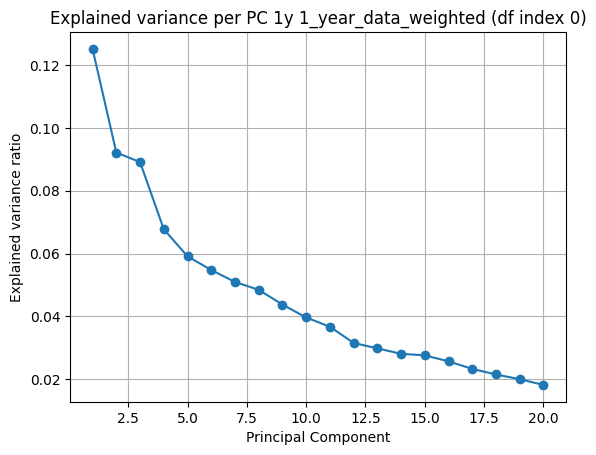

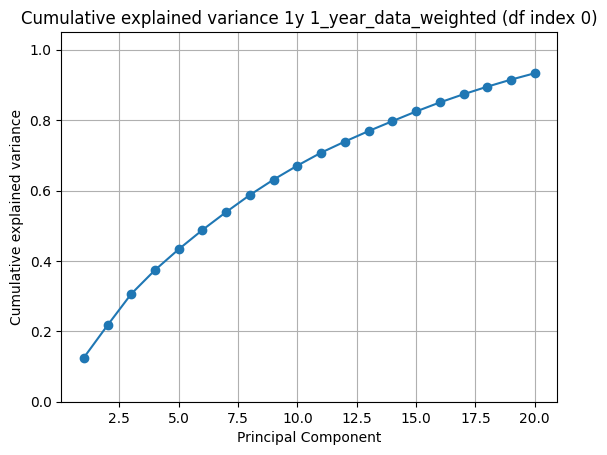

In [0]:
# pca_dfs_3m = run_pca_pipeline(dfs_3m, PCA_columns, "3m", k=20, modifier_fn=three_month_modifier_for_pca, pca_feature_col="features_with_pca")
pca_dfs_1y = run_pca_pipeline(dfs_1y, PCA_1y, "1y", k=20, pca_feature_col="features_with_pca")

## Main Dataset creation

In [0]:
# Leveraged from Eric
def create_delay_groups(df):
    df_new = df.withColumn(
        "DEP_DELAY_GROUP_CLASSIFIED",
        when(col("DEP_DELAY_GROUP").isin(-2, -1), "early")
        .when(col("DEP_DELAY_GROUP").isin(0), "on_time")
        .otherwise("delayed"),
    )
    return df_new

In [0]:
def prep_for_rf(df, label_col="DEP_DELAY_GROUP_CLASSIFIED"):
    banned = {label_col, "DEP_DELAY_GROUP"}

    # 1) clear any stale ML metadata
    df = df.select([F.col(c).alias(c, metadata={}) for c in df.columns])

    # 2) normalize strings, then cast ALL non-label strings to double
    for c, t in df.dtypes:
        if t == "string" and c not in banned:
            df = df.withColumn(c, F.trim(F.col(c)))
            df = df.withColumn(c, F.when(F.col(c) == "", None).otherwise(F.col(c)))
            df = df.withColumn(c, F.col(c).cast("double"))  # non-numeric → null

    # 3) fill NaNs in numerics (so assembler/RF won’t choke)
    numeric_cols = [c for c, t in df.dtypes if c not in banned and t in {"double","float","int","bigint"}]
    if numeric_cols:
        df = df.fillna(0.0, subset=numeric_cols)
    else:
        raise ValueError("Still no numeric columns after casting — check schema/label name.")

    return df

In [0]:
## SPLIT_FN
def train_test_split(df, *args):
    # Train / test split
    train_df, test_df = df.randomSplit([0.8, 0.2], seed=1234)
    return train_df, test_df

def month_split(df, min_month, max_month):
    """ month split train/eval and test/predict - greater than and equal to max month"""
    train_df = df.filter(month(to_timestamp(col("DATE"))) <= min_month)
    test_df = df.filter(month(to_timestamp(col("DATE"))) >= max_month)
    return train_df, test_df
### END SPLIT FN

def month_split_end_at_max_month(df, min_month, max_month):
    train_df = df.filter(month(to_timestamp(col("DATE"))) <= min_month)
    test_df = df.filter(month(to_timestamp(col("DATE"))) == max_month)
    return train_df, test_df

def get_feature_cols(df, label_col="DEP_DELAY_GROUP_CLASSIFIED"):
    # Numeric feature columns only (excluding label and raw group)
    feature_cols = [
        c for c, t in df.dtypes
        if t in ("int", "bigint", "double", "float")
        and c not in [label_col, "DEP_DELAY_GROUP"]
    ]
    return feature_cols

def drop_columns(df, columns_to_drop):
    for col_name in columns_to_drop:
        df = df.drop(col_name)
    return df

In [0]:
def get_train_test_filter_df(
    item, split_fn, drop_cols, lower, upper, elected_cols=None, pca_col="features_with_pca"
):
    df = item["df"]
    name = item["name"]
    df_dg = create_delay_groups(df)
    df_clean = prep_for_rf(df_dg)
    # Only drop columns that exist, but never drop DEP_DELAY_GROUP_CLASSIFIED
    cols_to_drop = [col for col in drop_cols if col in df_clean.columns and col != "DEP_DELAY_GROUP_CLASSIFIED"]
    df_filtered = drop_columns(df_clean, cols_to_drop)
    if elected_cols is not None:
        # Always include the PCA column if it exists and DEP_DELAY_GROUP_CLASSIFIED
        cols_to_select = []
        if pca_col in df_filtered.columns:
            pass
            # cols_to_select.append(pca_col). # Ignore PCA column vector due to memory issues
        cols_to_select += [c for c in elected_cols if c != pca_col and c in df_filtered.columns]
        if "DEP_DELAY_GROUP_CLASSIFIED" not in cols_to_select and "DEP_DELAY_GROUP_CLASSIFIED" in df_filtered.columns:
            cols_to_select.append("DEP_DELAY_GROUP_CLASSIFIED")
        df_filtered = df_filtered.select(*cols_to_select)
        feature_cols = [c for c in cols_to_select if c != "DEP_DELAY_GROUP_CLASSIFIED"]
    else:
        feature_cols = [c for c in df_filtered.columns if c != "DEP_DELAY_GROUP_CLASSIFIED"]
    train_df, test_df = split_fn(df_filtered, lower, upper)

    return {
        "name": name,
        "train_df": train_df.cache(),
        "test_df": test_df.cache(),
        "feature_cols": feature_cols
    }

def model_pipeline(df_list, split_fn, lower, upper, drop_cols=None, elected_cols=None):
    df_split = []
    if drop_cols is None:
        drop_cols = []

    for item in df_list:
        df_items = get_train_test_filter_df(item, split_fn, drop_cols, lower, upper, elected_cols)
        df_split.append(df_items)

    return df_split

### Dataset curating

In [0]:
for i, item in enumerate(dfs_1y):
    print(f"Column names for dfs_1y[{i}] ({item['name']}):")
    print(item["df"].columns)

# for i, item in enumerate(dfs_3m):
#     print(f"Column names for dfs_3m[{i}] ({item['name']}):")
#     print(item["df"].columns)

Column names for dfs_1y[0] (1_year_data_weighted):
['HourlyPrecipitation', 'HourlySeaLevelPressure', 'HourlyAltimeterSetting', 'DEP_TIME', 'DEP_DELAY_GROUP', 'HourlyWetBulbTemperature', 'HourlyStationPressure', 'HourlyWindSpeed', 'HourlyRelativeHumidity', 'HourlyDewPointTemperature', 'HourlyDryBulbTemperature', 'HourlyVisibility', 'CRS_ARR_TIME', 'LATITUDE', 'DATE', 'STATION', 'two_hours_prior_depart_UTC', 'sched_depart_date_time_UTC', 'sched_depart_date_time', 'DISTANCE_GROUP', 'DISTANCE', 'four_hours_prior_depart_UTC', 'DAY_OF_MONTH', 'ORIGIN_AIRPORT_ID', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'ELEVATION', 'dest_airport_lon', 'DEST_AIRPORT_ID', 'origin_airport_lon', 'origin_airport_lat', 'day_of_week', 'dest_airport_lat', 'FL_DATE', 'QUARTER', 'LONGITUDE', 'CRS_ELAPSED_TIME', 'month', 'ts', 'HourlyWindDirection_deg', 'wind_dir_sin', 'wind_dir_cos', 'HourlyPrecipitation_was_missing', 'has_CLR', 'CLR_height_ft', 'has_FEW', 'FEW_height_ft', 'has_SCT', 'SCT_height_ft', 'has_BKN', 'BKN_heig

In [0]:
# df_split = model_pipeline(pca_dfs_3m, train_test_split,  9, 10, cols_to_remove, target_selected)
df_split_1y = model_pipeline(pca_dfs_1y, month_split, 9, 10, cols_to_remove,  target_selected)

In [0]:
# for i, item in enumerate(df_split):
#     print(f"Column names for dfs_3m[{i}] ({item['name']}):")
#     print(item["train_df"].columns)
#     print(f"First 5 rows of train_df for dfs_3m[{i}] ({item['name']}):")
#     display(item["train_df"].limit(5))

for i, item in enumerate(df_split_1y):
    print(f"Column names for dfs_1y[{i}] ({item['name']}):")
    print(item["train_df"].columns)
    print(f"First 5 rows of train_df for dfs_1y[{i}] ({item['name']}):")
    display(item["train_df"].limit(5))

Column names for dfs_1y[0] (1_year_data_weighted):
['day_of_week', 'has_SCT', 'HourlyDryBulbTemperature', 'is_us_holiday', 'OP_CARRIER_FL_NUM', 'is_summer_peak', 'hour_of_day', 'CLR_height_ft', 'dest_airport_lat', 'BKN_height_ft', 'origin_airport_lat', 'DISTANCE', 'HourlyPrecipitation_was_missing', 'DEST_AIRPORT_ID', 'LONGITUDE', 'LATITUDE', 'DAY_OF_MONTH', 'QUARTER', 'ORIGIN_AIRPORT_ID', 'ELEVATION', 'has_OVC', 'dest_airport_lon', 'has_CLR', 'HourlyVisibility', 'has_FEW', 'SCT_height_ft', 'HourlyPrecipitation', 'HourlyWetBulbTemperature', 'HourlyAltimeterSetting', 'is_weekend', 'HourlyWindDirection_deg', 'season', 'FEW_height_ft', 'OVC_height_ft', 'is_holiday_window', 'has_BKN', 'HourlyRelativeHumidity', 'HourlyWindSpeed', 'wind_dir_sin', 'DEP_DELAY_GROUP_CLASSIFIED']
First 5 rows of train_df for dfs_1y[0] (1_year_data_weighted):


day_of_week,has_SCT,HourlyDryBulbTemperature,is_us_holiday,OP_CARRIER_FL_NUM,is_summer_peak,hour_of_day,CLR_height_ft,dest_airport_lat,BKN_height_ft,origin_airport_lat,DISTANCE,HourlyPrecipitation_was_missing,DEST_AIRPORT_ID,LONGITUDE,LATITUDE,DAY_OF_MONTH,QUARTER,ORIGIN_AIRPORT_ID,ELEVATION,has_OVC,dest_airport_lon,has_CLR,HourlyVisibility,has_FEW,SCT_height_ft,HourlyPrecipitation,HourlyWetBulbTemperature,HourlyAltimeterSetting,is_weekend,HourlyWindDirection_deg,season,FEW_height_ft,OVC_height_ft,is_holiday_window,has_BKN,HourlyRelativeHumidity,HourlyWindSpeed,wind_dir_sin,DEP_DELAY_GROUP_CLASSIFIED
4,0,4.0,0,5076,0,22,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,5,1,10577,486.2,0,-83.3,0,10.0,0,0,0.0,3.0,30.13,0,300.0,0.0,0,0,0,0,76.0,6.0,-0.8660254037844386,delayed
2,0,15.0,0,5212,0,22,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,17,1,10577,486.2,0,-83.3,0,10.0,0,0,0.0,12.0,29.78,0,10.0,0.0,0,0,1,0,59.0,6.0,0.17364817766693033,on_time
2,0,72.0,0,5097,1,19,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,21,3,10577,486.2,0,-83.3,0,10.0,0,0,0.0,66.0,29.7,0,350.0,0.0,0,0,0,0,71.0,15.0,-0.1736481776669304,on_time
5,0,65.0,0,4896,1,10,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,31,3,10577,486.2,0,-83.3,0,10.0,0,0,0.0,61.0,29.94,0,260.0,0.0,0,0,0,0,78.0,7.0,-0.984807753012208,early
7,0,58.0,0,5457,1,10,0,42.2,0,42.2,378.0,0,11433,-75.98,42.2068,23,3,10577,486.2,0,-83.3,0,10.0,0,0,0.0,55.0,30.1,1,50.0,0.0,0,0,0,0,84.0,5.0,0.766044443118978,early


### Modeling

In [0]:
def train_random_forest(df_train, df_test, features_col, label_col="DEP_DELAY_GROUP_CLASSIFIED"):
    """
    Train a Random Forest classifier on the given dataframe.
    Returns (model, predictions).
    """
    stages = []

    # Index string label -> numeric label
    label_indexer = StringIndexer(
        inputCol=label_col,
        outputCol="label",
        handleInvalid="keep",
    )
    stages.append(label_indexer)

    # Assemble features if features_col is a list
    if isinstance(features_col, list):
        assembler = VectorAssembler(
            inputCols=features_col,
            outputCol="features",
            handleInvalid="keep",
        )
        stages.append(assembler)
        features_col_name = "features"
    else:
        features_col_name = features_col

    # Random Forest classifier
    rf = RandomForestClassifier(
        featuresCol=features_col_name,
        labelCol="label",
        predictionCol="prediction",
        probabilityCol="probability",
        rawPredictionCol="rawPrediction",
        weightCol="class_weight",
        numTrees=150,
        maxDepth=8,
        seed=42,
    )
    stages.append(rf)

    rf_pipeline = Pipeline(stages=stages)

    rf_model = rf_pipeline.fit(df_train)

    pred_test = rf_model.transform(df_test)

    return rf_model, pred_test

In [0]:
def train_xgboost(df_train, df_test, features_col, label_col="DEP_DELAY_GROUP_CLASSIFIED"):
    """
    Train an XGBoost classifier using xgboost.spark.SparkXGBClassifier
    on the given dataframe. Returns (model, predictions).
    """
    stages = []

    # Index string label -> numeric label
    label_indexer = StringIndexer(
        inputCol=label_col,
        outputCol="label",
        handleInvalid="keep",
    )
    stages.append(label_indexer)

    # Assemble features if features_col is a list
    if isinstance(features_col, list):
        assembler = VectorAssembler(
            inputCols=features_col,
            outputCol="features",
            handleInvalid="keep",
        )
        stages.append(assembler)
        features_col_name = "features"
    else:
        features_col_name = features_col

    # XGBoost classifier
    xgb = SparkXGBClassifier(
        features_col=features_col_name,
        label_col="label",
        weight_col="class_weight",
        max_depth=6,
        n_estimators=100,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        reg_alpha=0.0
    )
    stages.append(xgb)

    xgb_pipeline = Pipeline(stages=stages)

    xgb_model = xgb_pipeline.fit(df_train)

    pred_test = xgb_model.transform(df_test)

    return xgb_model, pred_test


In [0]:
def add_class_weights(label_col="DEP_DELAY_GROUP_CLASSIFIED", weight_col="class_weight"):
    """
    Returns an adjust_fn(train_df, test_df) that adds a class_weight column to train_df
    based on label distribution, and leaves test_df unchanged.
    """

    def _adjust(train_df, test_df):
        # counts per class on training set
        counts = train_df.groupBy(label_col).count().withColumnRenamed("count", "cnt")
        total = counts.agg(F.sum("cnt")).first()[0]
        k = counts.count()

        # w_c = N / (K * n_c)  -> average weight ~ 1
        weights_df = counts.withColumn(
            weight_col,
            (F.lit(float(total)) / (F.lit(float(k)) * F.col("cnt")))
        )

        # attach weights to training rows
        train_with_weights = train_df.join(
            weights_df.select(label_col, weight_col),
            on=label_col,
            how="left"
        )

        return train_with_weights, test_df

    return _adjust

In [0]:
def modeling_pipeline(df_items, modeling_fn, model_save_path="", model_name="", *adjust_fns):
    save_path = f"{model_save_path}/{model_name}"
    pred_test_save_path = f"{model_save_path}/{model_name}_pred_test"

    # Try to load model and predictions if they exist
    try:
        model = PipelineModel.load(save_path)
        pred_test = spark.read.parquet(pred_test_save_path)
        print(f"Loaded model from {save_path}")
        print(f"Loaded predictions from {pred_test_save_path}")
        return {
            "model": model,
            "pred_test": pred_test,
            "name": model_name
        }
    except Exception:
        print(f"training {model_name}")

    train_df = df_items["train_df"]
    test_df = df_items["test_df"]
    feature_cols = df_items["feature_cols"]

    # Make any adjustments as needed
    for adjust_fn in adjust_fns:
        train_df, test_df = adjust_fn(train_df, test_df)

    model, pred_test = modeling_fn(train_df, test_df, feature_cols)

    if model_save_path != "" and model_name != "":
        print(f"Model saved to {save_path}")
        model.write().overwrite().save(save_path)
        pred_test.write.mode("overwrite").parquet(pred_test_save_path)
        print(f"Predictions saved to {pred_test_save_path}")

    return {
        "model": model,
        "pred_test": pred_test,
        "name": model_name
    }

In [0]:
def train_models(df_split, modeling_fn, model_prefix):
    models = []
    for i in range(len(df_split)):
        model = modeling_pipeline(
            df_split[i],
            modeling_fn,
            f"dbfs:/student-groups/Group_4_1/{model_prefix}",
            df_split[i]["name"],
            add_class_weights()
        )
        models.append(model)
    return models

In [0]:
def delete_model_if_exists(model_save_path, model_name):
    save_path = f"{model_save_path}/{model_name}"
    pred_test_save_path = f"{model_save_path}/{model_name}_pred_test"
    # Remove model directory if exists
    try:
        dbutils.fs.rm(save_path, True)
        print(f"Deleted model directory: {save_path}")
    except Exception as e:
        print(f"Could not delete model directory: {save_path} ({e})")
    # Remove predictions directory if exists
    try:
        dbutils.fs.rm(pred_test_save_path, True)
        print(f"Deleted predictions directory: {pred_test_save_path}")
    except Exception as e:
        print(f"Could not delete predictions directory: {pred_test_save_path} ({e})")

In [0]:
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[0]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[1]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[2]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[3]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model", df_split[4]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[0]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[1]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[2]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[3]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model", df_split[4]["name"])


# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[0]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[1]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[2]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[3]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/xgboost_model_1y", df_split_1y[4]["name"])

# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model1_1y", df_split_1y[0]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model2_1y", df_split_1y[1]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model3_1y", df_split_1y[2]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model4_1y", df_split_1y[3]["name"])
# delete_model_if_exists("dbfs:/student-groups/Group_4_1/rf_model5_1y", df_split_1y[4]["name"])

## model run - EXPERIMENTS

XG Boost

In [0]:
# xg_models = train_models(df_split, train_xgboost, "xgboost_model")

In [0]:
xg_models_1y = train_models(df_split_1y, train_xgboost, "xgboost_model_1y")

Loaded model from dbfs:/student-groups/Group_4_1/xgboost_model_1y/1_year_data_weighted
Loaded predictions from dbfs:/student-groups/Group_4_1/xgboost_model_1y/1_year_data_weighted_pred_test


Random forest

In [0]:
# rf_models = train_models(df_split, train_random_forest, "rf_model")

In [0]:
rf_models_1y = train_models(df_split_1y, train_random_forest, "rf_model_1y")

Loaded model from dbfs:/student-groups/Group_4_1/rf_model_1y/1_year_data_weighted
Loaded predictions from dbfs:/student-groups/Group_4_1/rf_model_1y/1_year_data_weighted_pred_test


## Evaluation

In [0]:
def plot_confusion_matrix(predictions, indexer_model, title: str):
    """
    predictions: DataFrame with columns 'label' and 'prediction'
    indexer_model: fitted StringIndexerModel used for labels
    title: title for the heatmap
    """
    confusion_pd = predictions.select(['label', 'prediction']).toPandas()

    cm = confusion_matrix(confusion_pd['label'], confusion_pd['prediction'])

    label_names = indexer_model.labels

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        xticklabels=label_names,
        yticklabels=label_names
    )
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return cm

In [0]:
def evaluate_model(model, pred_test, title):
    evaluator_acc = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="accuracy",
    )

    evaluator_f1 = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="f1",
    )

    evaluator_prec = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedPrecision",
    )

    evaluator_rec = MulticlassClassificationEvaluator(
        labelCol="label",
        predictionCol="prediction",
        metricName="weightedRecall",
    )

    test_accuracy = evaluator_acc.evaluate(pred_test)
    test_f1 = evaluator_f1.evaluate(pred_test)
    test_precision = evaluator_prec.evaluate(pred_test)
    test_recall = evaluator_rec.evaluate(pred_test)

    print(f"=== {title} ===")
    print(f"Test accuracy : {test_accuracy:.4f}")
    print(f"Test F1-score: {test_f1:.4f}")
    print(f"Test precision: {test_precision:.4f}")
    print(f"Test recall   : {test_recall:.4f}")

    indexer_model = model.stages[0]
    cm = plot_confusion_matrix(
        pred_test,
        indexer_model=indexer_model,
        title=f"Confusion Matrix - {title}",
    )

    return test_accuracy, test_f1, test_precision, test_recall, cm

In [0]:
# # XGBoost model evaluations
# for model in xg_models:
#     evaluate_model(model["model"], model["pred_test"], f"XGBoost - {model['name']}")

=== XGBoost 1y - 1_year_data_weighted ===
Test accuracy : 0.5330
Test F1-score: 0.5344
Test precision: 0.5358
Test recall   : 0.5330


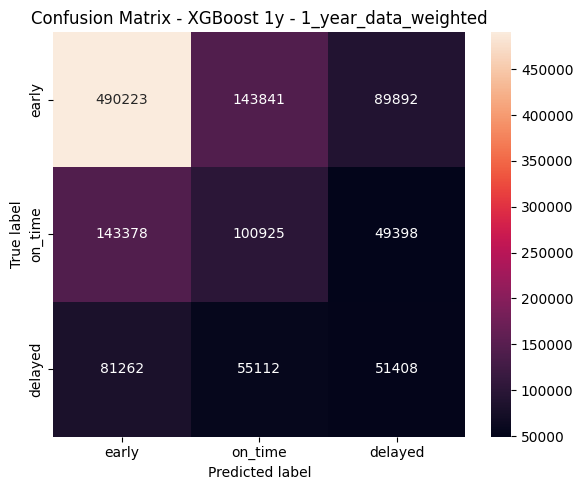

In [0]:
# XGBoost 1y model evaluations
cm_xg_1y = []
for model in xg_models_1y:
    _, _, _, _, cm = evaluate_model(model["model"], model["pred_test"], f"XGBoost 1y - {model['name']}")
    cm_xg_1y.append(cm)

In [0]:
# # Random Forest model evaluations
# for model in rf_models:
#     evaluate_model(model["model"], model["pred_test"], f"Random Forest - {model['name']}")

=== Random Forest 1y - 1_year_data_weighted ===
Test accuracy : 0.4931
Test F1-score: 0.5051
Test precision: 0.5252
Test recall   : 0.4931


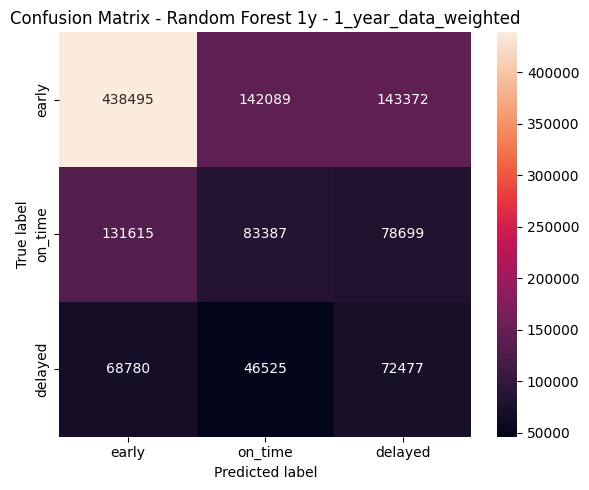

In [0]:
# Random Forest 1y model evaluations
cm_rf_1y = []
for model in rf_models_1y:
    _, _, _, _, cm = evaluate_model(model["model"], model["pred_test"], f"Random Forest 1y - {model['name']}")
    cm_rf_1y.append(cm)

In [0]:
cm_xg_1y

[array([[490223, 143841,  89892],
        [143378, 100925,  49398],
        [ 81262,  55112,  51408]])]

In [0]:
cm_rf_1y

[array([[438495, 142089, 143372],
        [131615,  83387,  78699],
        [ 68780,  46525,  72477]])]

## Cross Validation

In [0]:
def rolling_month_cv(df, month_split_function, cols_to_remove, start_month=3, end_month=4, chosen_cols=None):
    """
    - Full dataframe or target dataframe
    - Month split function
    - Columns to remove from the dataframe
    - Start month for rolling CV
    - End month for rolling CV
    - Chosen columns for modeling
    """
    results = []
    for test_month in range(start_month, end_month):
        # Use get_train_test_filter_df for train/test split
        split_df = get_train_test_filter_df(
            df, 
            month_split_function, 
            cols_to_remove, 
            test_month,
            test_month + 1, 
            chosen_cols
        )

        items = {
            "name": f"train_{test_month}_mths-test_mth_{test_month + 1}",
            "train_df":  split_df["train_df"],
            "test_df":  split_df["test_df"],
            "feature_cols":  split_df["feature_cols"],
        }
        results.append(items)

    return results

In [0]:
def prepare_cv_pipeline(dfs, cols_to_remove, target):
    cv_datasets = []
    for df in dfs:
        res = rolling_month_cv(
            df,
            month_split_end_at_max_month,
            cols_to_remove,
            3,
            9,
            target
        )
        cv_datasets.extend(res)

    return cv_datasets

cv_dataset = prepare_cv_pipeline(pca_dfs_1y, cols_to_remove, target_selected)

In [0]:
for cv in cv_dataset:
    print(cv["name"])

train_3_mths-test_mth_4
train_4_mths-test_mth_5
train_5_mths-test_mth_6
train_6_mths-test_mth_7
train_7_mths-test_mth_8
train_8_mths-test_mth_9


In [0]:
xg_cv = train_models(cv_dataset, train_xgboost, "weighted_xgboost_model_cv")
rf_cv = train_models(cv_dataset, train_random_forest, "weighted_rf_model_cv")

Loaded model from dbfs:/student-groups/Group_4_1/weighted_xgboost_model_cv/train_3_mths-test_mth_4
Loaded predictions from dbfs:/student-groups/Group_4_1/weighted_xgboost_model_cv/train_3_mths-test_mth_4_pred_test
Loaded model from dbfs:/student-groups/Group_4_1/weighted_xgboost_model_cv/train_4_mths-test_mth_5
Loaded predictions from dbfs:/student-groups/Group_4_1/weighted_xgboost_model_cv/train_4_mths-test_mth_5_pred_test
Loaded model from dbfs:/student-groups/Group_4_1/weighted_xgboost_model_cv/train_5_mths-test_mth_6
Loaded predictions from dbfs:/student-groups/Group_4_1/weighted_xgboost_model_cv/train_5_mths-test_mth_6_pred_test
Loaded model from dbfs:/student-groups/Group_4_1/weighted_xgboost_model_cv/train_6_mths-test_mth_7
Loaded predictions from dbfs:/student-groups/Group_4_1/weighted_xgboost_model_cv/train_6_mths-test_mth_7_pred_test
Loaded model from dbfs:/student-groups/Group_4_1/weighted_xgboost_model_cv/train_7_mths-test_mth_8
Loaded predictions from dbfs:/student-groups/

In [0]:
def rolling_evaluation(model_results, eval_fn, title_prefix=""):
    """
    Evaluate each CV split using eval_fn(model, pred_test, title).
    Returns a list of dicts with cv_name and individual metrics for CV calculation.
    """
    metrics = []
    for res in model_results:
        title = f"{title_prefix}{res['name']}"
        acc, f1, prec, rec, cm = eval_fn(res["model"], res["pred_test"], title)
        metrics.append({
            "cv_name": res["name"],
            "accuracy": acc,
            "f1": f1,
            "precision": prec,
            "recall": rec,
            "confusion_matrix": cm
        })
    return metrics

=== XGBoost CV - train_3_mths-test_mth_4 ===
Test accuracy : 0.5081
Test F1-score: 0.5217
Test precision: 0.5412
Test recall   : 0.5081


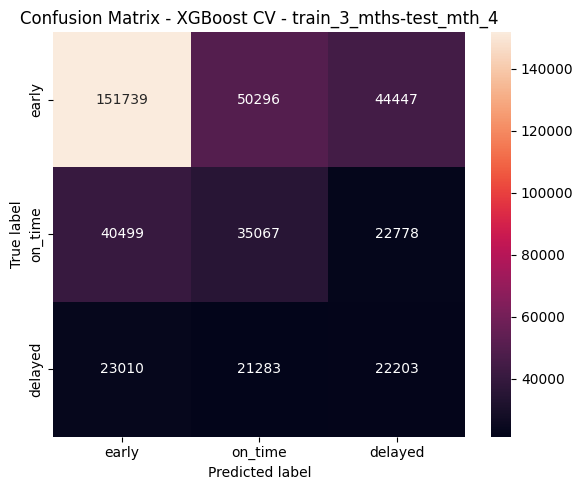

=== XGBoost CV - train_4_mths-test_mth_5 ===
Test accuracy : 0.5136
Test F1-score: 0.5221
Test precision: 0.5334
Test recall   : 0.5136


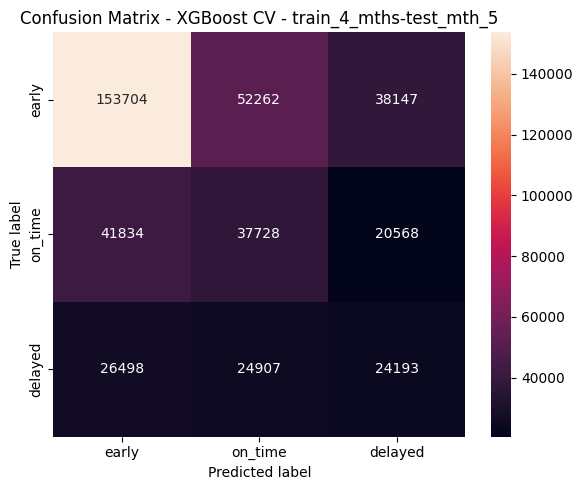

=== XGBoost CV - train_5_mths-test_mth_6 ===
Test accuracy : 0.4929
Test F1-score: 0.4984
Test precision: 0.5087
Test recall   : 0.4929


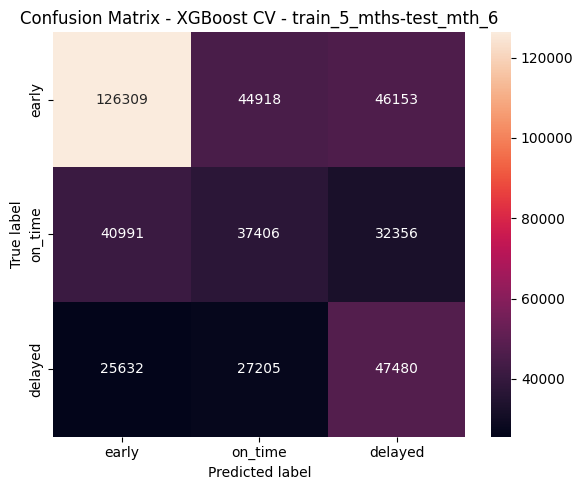

=== XGBoost CV - train_6_mths-test_mth_7 ===
Test accuracy : 0.4518
Test F1-score: 0.4633
Test precision: 0.5317
Test recall   : 0.4518


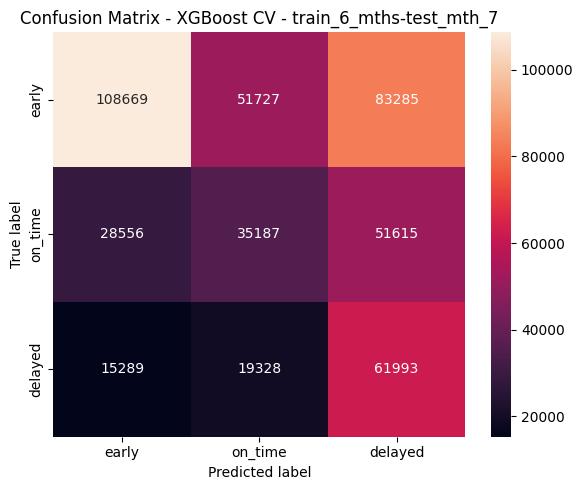

=== XGBoost CV - train_7_mths-test_mth_8 ===
Test accuracy : 0.4557
Test F1-score: 0.4737
Test precision: 0.5320
Test recall   : 0.4557


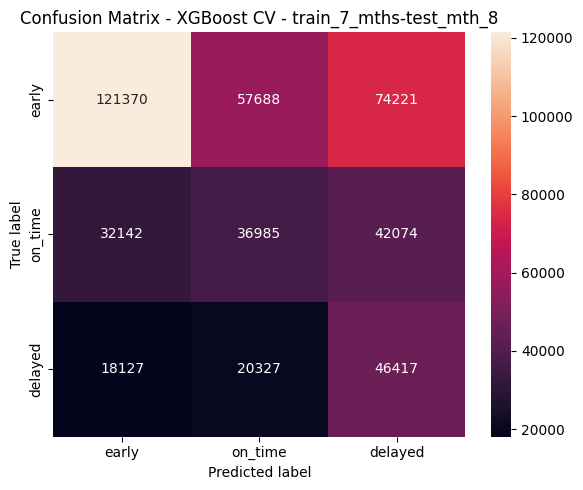

=== XGBoost CV - train_8_mths-test_mth_9 ===
Test accuracy : 0.4996
Test F1-score: 0.5299
Test precision: 0.5906
Test recall   : 0.4996


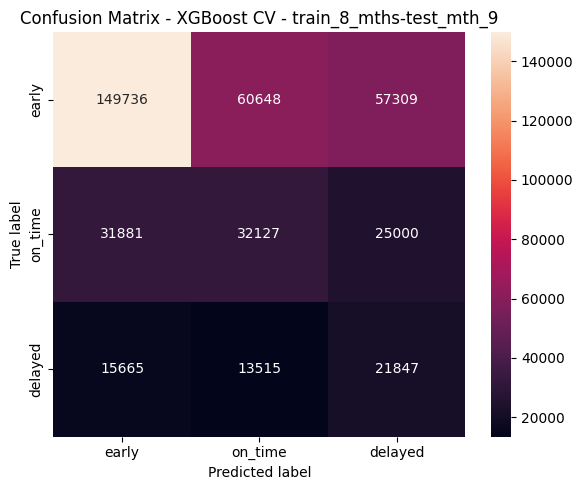

=== Random Forest CV - train_3_mths-test_mth_4 ===
Test accuracy : 0.5047
Test F1-score: 0.5077
Test precision: 0.5111
Test recall   : 0.5047


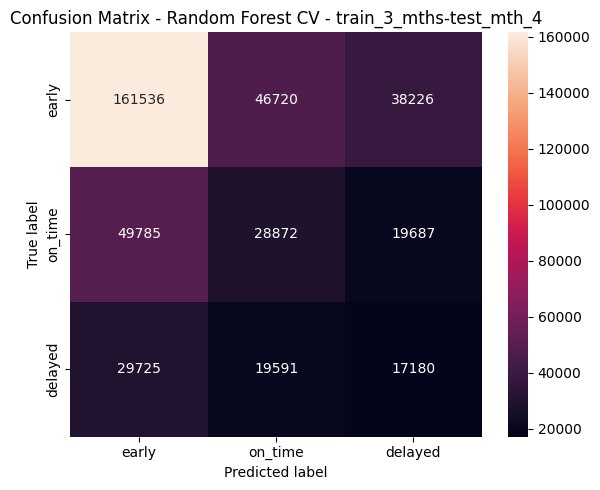

=== Random Forest CV - train_4_mths-test_mth_5 ===
Test accuracy : 0.5130
Test F1-score: 0.5165
Test precision: 0.5205
Test recall   : 0.5130


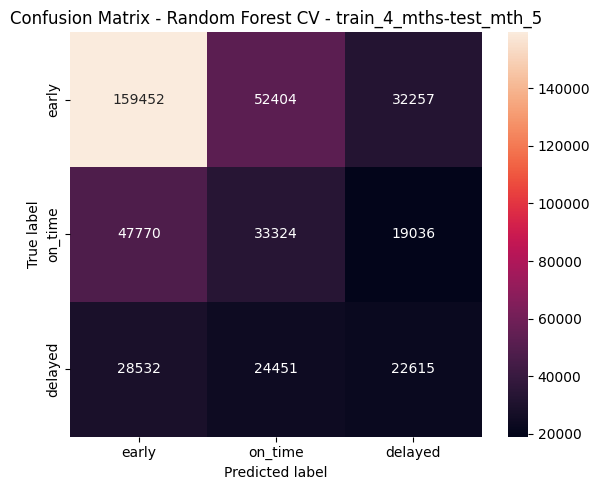

=== Random Forest CV - train_5_mths-test_mth_6 ===
Test accuracy : 0.4927
Test F1-score: 0.4871
Test precision: 0.4847
Test recall   : 0.4927


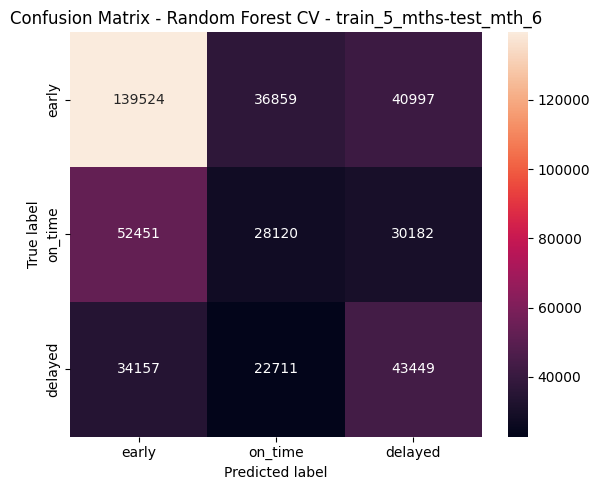

=== Random Forest CV - train_6_mths-test_mth_7 ===
Test accuracy : 0.4583
Test F1-score: 0.4601
Test precision: 0.5057
Test recall   : 0.4583


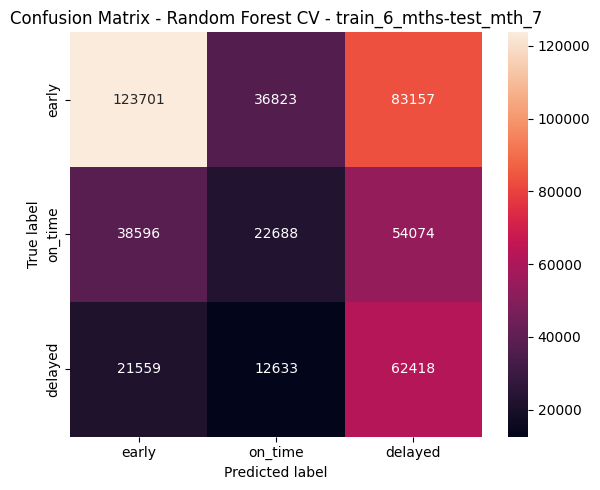

=== Random Forest CV - train_7_mths-test_mth_8 ===
Test accuracy : 0.4510
Test F1-score: 0.4651
Test precision: 0.5177
Test recall   : 0.4510


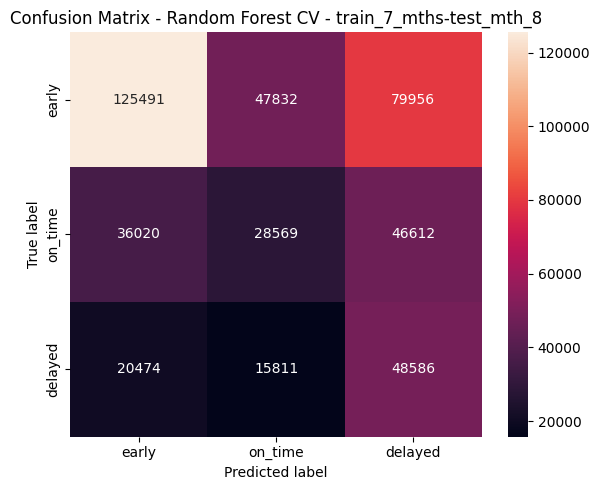

=== Random Forest CV - train_8_mths-test_mth_9 ===
Test accuracy : 0.4763
Test F1-score: 0.5088
Test precision: 0.5761
Test recall   : 0.4763


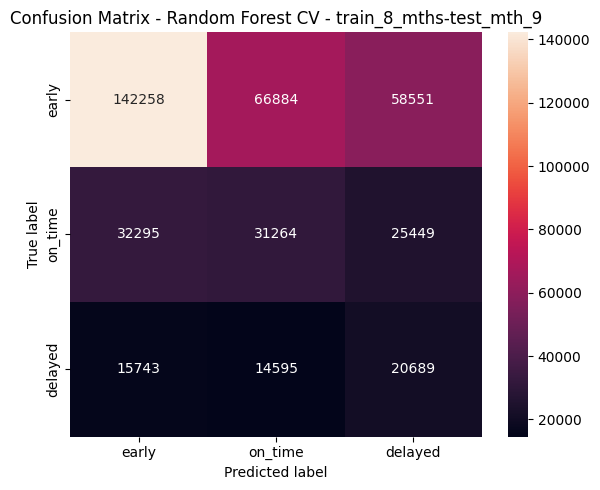

In [0]:
xg_cv_metrics = rolling_evaluation(xg_cv, evaluate_model, title_prefix="XGBoost CV - ")
rf_cv_metrics = rolling_evaluation(rf_cv, evaluate_model, title_prefix="Random Forest CV - ")

In [0]:
# Convert metrics lists to DataFrame for aggregation
xg_cv_metrics_df = pd.DataFrame(xg_cv_metrics)
rf_cv_metrics_df = pd.DataFrame(rf_cv_metrics)

# Compute mean for each metric
xg_cv_avg_metrics = xg_cv_metrics_df[["accuracy", "f1", "precision", "recall"]].mean()
rf_cv_avg_metrics = rf_cv_metrics_df[["accuracy", "f1", "precision", "recall"]].mean()

print("XGBoost CV average metrics:")
print(xg_cv_avg_metrics)

print("\nRandom Forest CV average metrics:")
print(rf_cv_avg_metrics)

XGBoost CV average metrics:
accuracy     0.486959
f1           0.501534
precision    0.539581
recall       0.486959
dtype: float64

Random Forest CV average metrics:
accuracy     0.482661
f1           0.490875
precision    0.519302
recall       0.482661
dtype: float64


## Confusion matrix for specific class

In [0]:
def precision_recall_f1_accuracy_for_class(cls, cm):
    TP = cm[cls, cls]
    FN = cm[cls, :].sum() - TP
    FP = cm[:, cls].sum() - TP
    TN = cm.sum() - TP - FN - FP

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + TN) > 0 else 0

    return precision, recall, f1, accuracy

In [0]:
# DM for field delayed
res_delay_xg_1y = precision_recall_f1_accuracy_for_class(2, cm_xg_1y[0])

res_delay_rf_1y = precision_recall_f1_accuracy_for_class(2, cm_rf_1y[0])

In [0]:
res_delay_xg_cv = []
for i in xg_cv_metrics:
    res = precision_recall_f1_accuracy_for_class(2, i["confusion_matrix"])
    res_delay_xg_cv.append(res)

res_delay_rf_cv = []
for i in rf_cv_metrics:
    res = precision_recall_f1_accuracy_for_class(2, i["confusion_matrix"])
    res_delay_rf_cv.append(res)

In [0]:
report_metrics = lambda x: f"Precision: {x[0]}, Recall: {x[1]}, F1: {x[2]}, Accuracy: {x[3]}"

report_metrics(res_delay_xg_1y)

'Precision: 0.2695780763301136, Recall: 0.2737642585551331, F1: 0.2716550412175016, Accuracy: 0.7713165079278171'

In [0]:
report_metrics(res_delay_rf_1y)

'Precision: 0.24606176242921357, Recall: 0.38596351087963704, F1: 0.30052868368129704, Accuracy: 0.7201218809081172'

In [0]:
# Get all metrics of a certain obs, then sum and finally take the average
def get_summary_of_cv(metrics):
    precision = []
    recall = []
    f1 = []
    accuracy = []

    for i in metrics:
        precision.append(i[0])
        recall.append(i[1])
        f1.append(i[2])
        accuracy.append(i[3])

    p = sum(precision) / len(precision)
    r = sum(recall) / len(recall)
    f = sum(f1) / len(f1)
    a = sum(accuracy) / len(accuracy)

    print(report_metrics((p, r, f, a)))

In [0]:
get_summary_of_cv(res_delay_xg_cv)

Precision: 0.2878035825564977, Recall: 0.45732707155224395, F1: 0.3481041679275902, Accuracy: 0.6950285469576273


In [0]:
get_summary_of_cv(res_delay_rf_cv)

Precision: 0.2835778861670424, Recall: 0.4357715928610792, F1: 0.3350480778351635, Accuracy: 0.6955020989917803


Grid Search optimizations